# Requirements

##### Requirements are found [here](https://....)

---

## Connect to the cluster

Run this command in separate terminal to forward port from Katana controller node

```gcloud compute ssh --zone us-east1-b --project katana-internal14 katana-controller -- -NL 8080:127.0.0.1:8080 -vvv ```

Connect local Docker container to Katana Controller

In [1]:
import os                                                                        
import time                                                                      
import pandas as pd
from timeit import default_timer as timer

from katana import remote
from katana.remote import import_data
from katana.remote.import_data import Operation
cluster_name="katana-internal14"
num_partitions = 1


os.environ["KATANA_SERVER_ADDRESS"] = "host.docker.internal:8080"

In [148]:
remote.Client().widgets().dashboard()

## Setup for Splink

Insall the following :

```
pip install splink
pip install pyspark
pip install altair

apt-get update
apt install default-jre
```
For spark, either install it, or use the utility_functions/demo_utils.py file...


In [3]:
import pandas as pd 
import logging 
import pyspark
from splink import Splink
from utility_functions.demo_utils import get_spark

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

spark = get_spark() # See utility_functions/demo_utils.py for how to set up Spark

21/09/20 00:47:26 WARN SimpleFunctionRegistry: The function jaro_winkler_sim replaced a previously registered function.
21/09/20 00:47:26 WARN SimpleFunctionRegistry: The function dmetaphone replaced a previously registered function.


In [4]:
df = spark.read.csv("fake_1000.csv", header=True)
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Robert|   Alan|1971-06-24|  null| robert255@smith.net|    0|
|        1|    Robert|  Allen|1971-05-24|  null| roberta25@smith.net|    0|
|        2|       Rob|  Allen|1971-06-24|London| roberta25@smith.net|    0|
|        3|    Robert|   Alen|1971-06-24| Lonon|                null|    0|
|        4|     Grace|   null|1997-04-26|  Hull|grace.kelly52@jon...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



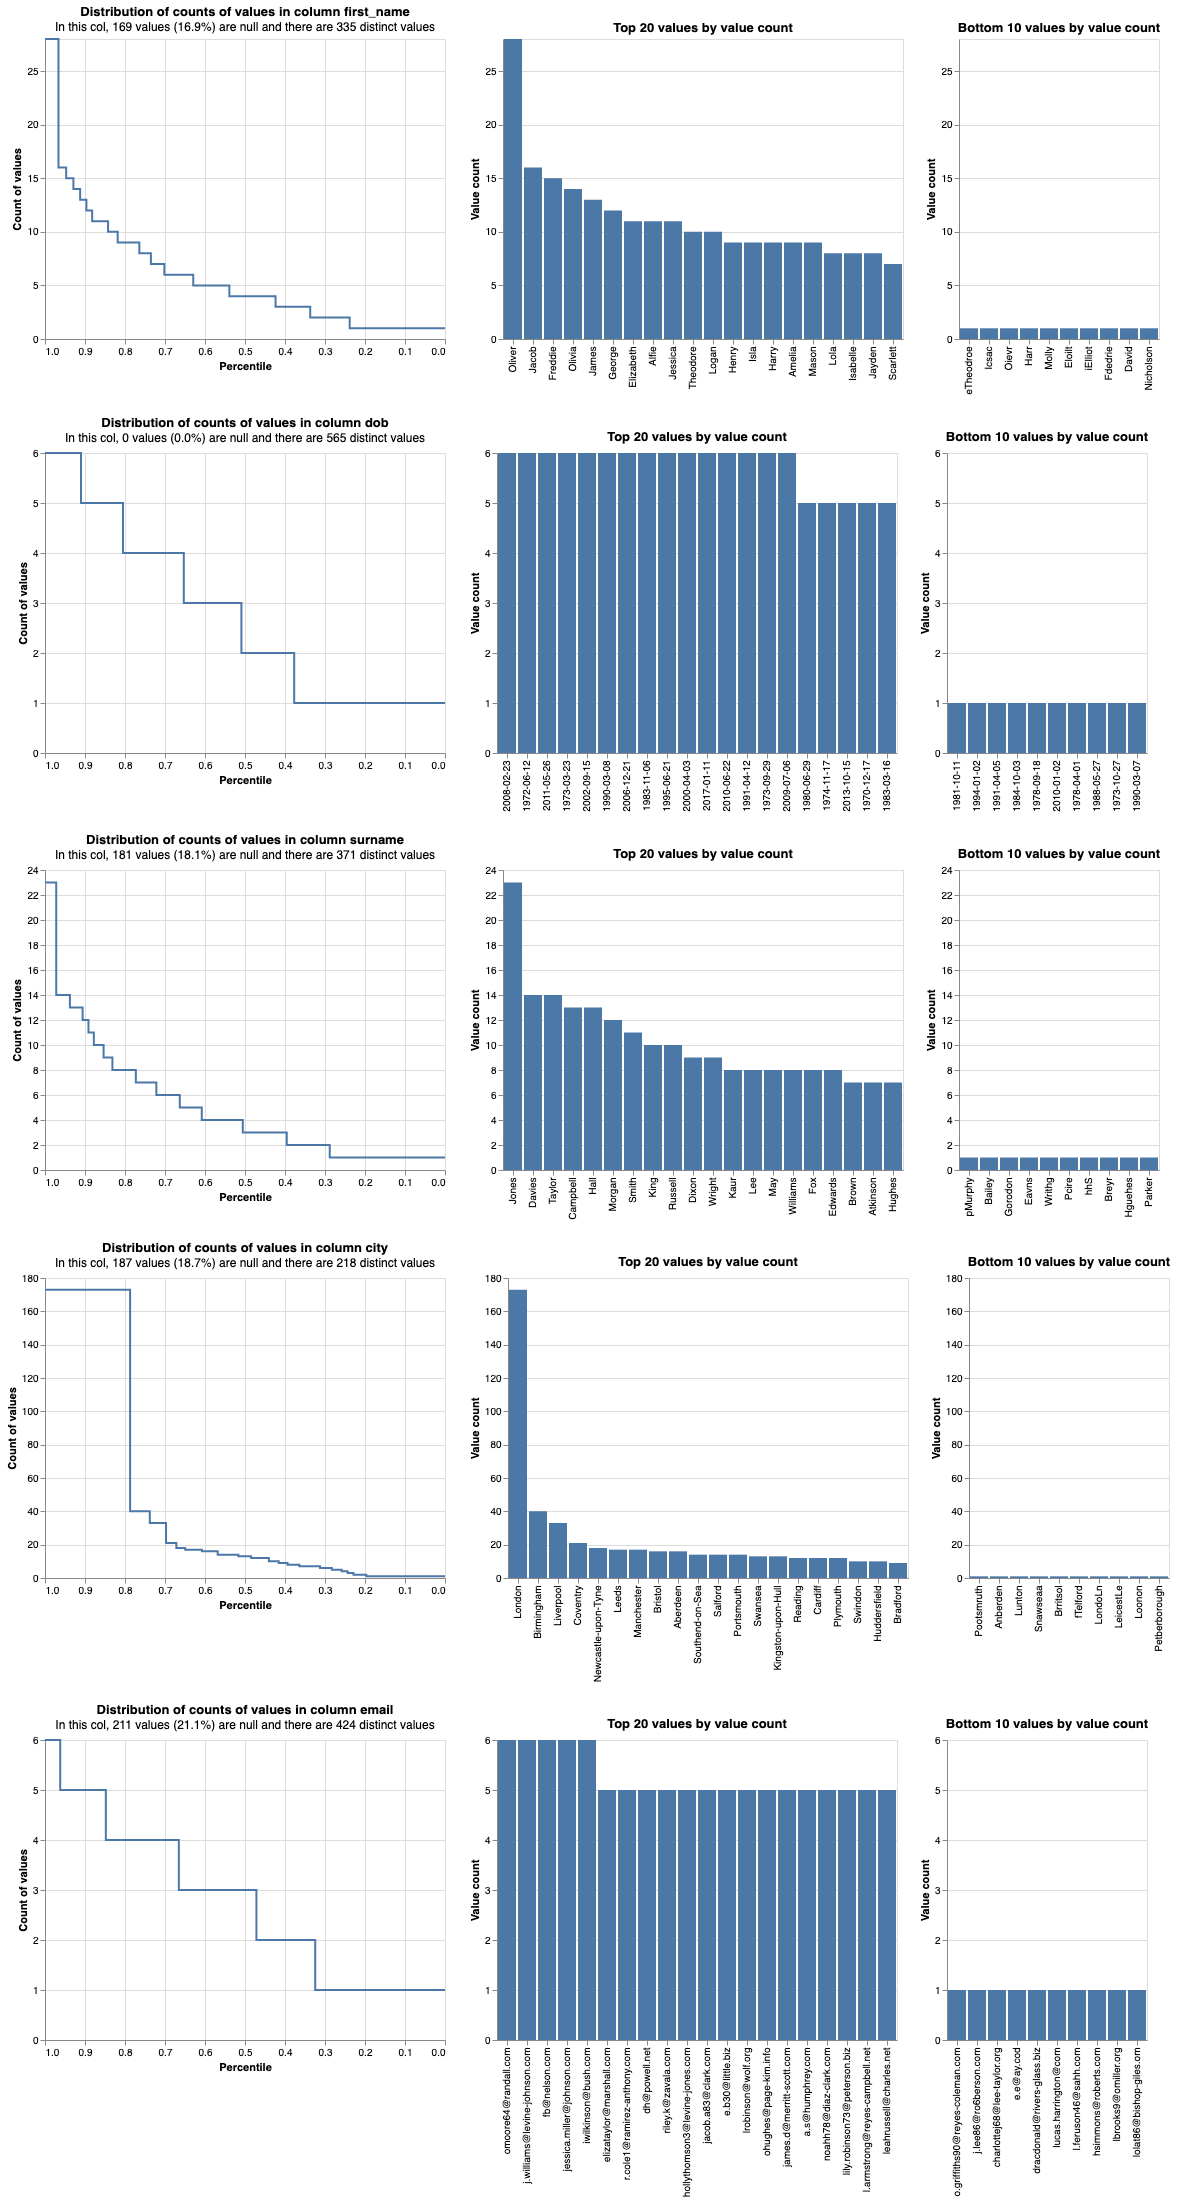

In [5]:
from splink.profile import column_value_frequencies_chart
import altair as alt
alt.renderers.enable('mimetype')
column_value_frequencies_chart(['first_name', "surname", "dob", "city", "email"], df, spark)

In [6]:
raw_records = (
  spark
    .read
    .format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("accounts.csv")
)

#raw_records.write.mode("overwrite").format("delta").saveAsTable("raw_records")
raw_records.write.mode("overwrite").saveAsTable("raw_records")
print(raw_records)

AnalysisException: Can not create the managed table('`raw_records`'). The associated location('file:/home/jovyan/host/external/katana/python/examples/spark-warehouse/raw_records') already exists.

In [ ]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.ssn = r.ssn",
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "term_frequency_adjustments": True},
        {
            "col_name": "phone",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email_addr"
        },
              {
            "col_name": "ssn"
        }
    ]
}
from splink import Splink
linker = Splink(settings, raw_records, spark)
raw_records_entities = linker.get_scored_comparisons()
display(raw_records_entities.take(10))

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.9 for key ssn, level 1
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.015730559825897217 for key first_name, level 0
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.0004532039165496826 for key proportion_of_matches
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.0004672110080718994 for key proportion_of_matches
INFO:splink.iterate:Iteration 4 complete
INFO:splink.model:The maximum change in parameters was 0.00046196579933166504 for key proportion_of_matches
INFO:splink.iterate:Iteration 5 complete
INFO:splink.model:The maximum change in parameters was 0.0004565715789794922 for key proportion_of_matches
INFO:splink.iterate:Iteration 6 complete
INFO:splink.model:The maximum change in parameters was 0.00045120716094970703 for key proportion_of_

In [ ]:
raw_records_entities.show(n=4)

In [ ]:
raw_records_entities.write.mode("overwrite").saveAsTable("raw_records_entities")

In [ ]:
model = linker.model
model.probability_distribution_chart()
model.bayes_factor_chart()
model.all_charts_write_html_file("splink_charts.html", overwrite=True)

In [ ]:
model.probability_distribution_chart()

In [18]:
from splink.intuition import intuition_report
df_e = linker.get_scored_comparisons()
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, model))

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.0003495514392852783 for key proportion_of_matches
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.00034436583518981934 for key proportion_of_matches
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.00033918023109436035 for key proportion_of_matches
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.00033399462699890137 for key proportion_of_matches
INFO:splink.iterate:Iteration 4 complete
INFO:splink.model:The maximum change in parameters was 0.00032889842987060547 for key proportion_of_matches
INFO:splink.iterate:Iteration 5 complete
INFO:splink.model:The maximum change in parameters was 0.0003237724304199219 for key proportion_of_matches
INFO:splink.iterate:Iteration 6 complete
INFO:splink.model:The maximum change in parameters was 0.0003186762


Initial probability of match (prior) = λ = 0.4921
------
Comparison of first_name.  Values are:             
first_name_l:                                      Ashleigh
first_name_r:                                      As
Comparison has:                                    2 levels
Level for this comparison:                         gamma_first_name = 0
m probability = P(level|match):                    0.9418
u probability = P(level|non-match):                0.996
Bayes factor = m/u:                                0.9456
New probability of match (updated belief):         0.4782

------
Comparison of phone.  Values are:                  
phone_l:                                           01614960257
phone_r:                                           01614960275
Comparison has:                                    2 levels
Level for this comparison:                         gamma_phone = 0
m probability = P(level|match):                    0.8231
u probability = P(level|non-match):       